In [1]:
import imageio.v3 as iio
import tqdm
import matplotlib.pyplot as plt
import numpy as np

import drjit as dr
import drjit.nn as nn
from drjit.opt import Adam, GradScaler
from drjit.auto.ad import (
    Texture2f,
    TensorXf,
    TensorXf16,
    Float16,
    Float32,
    ArrayXf16,
    Array2f,
    Array3f,
)
import mitsuba as mi

mi.set_variant("cuda_ad_rgb", "llvm_ad_rgb")

In [2]:

rng = dr.rng(seed=0)

In [3]:


def square_to_std_normal(sample: Array2f):
    r = dr.sqrt(-2.0 * dr.log(1.0 - sample[0]))
    phi = 2.0 * dr.pi * sample[1]

    s, c = dr.sincos(phi)
    return Array2f(c * r, s * r)


def log_std_normal_pdf(z: dr.ArrayBase):
    return dr.log(dr.inv_two_pi) - 0.5 * dr.square(z)

In [4]:


class SpiralDistr:
    def __init__(self) -> None: ...
    def sample(self, sample1: Float32, sample2: Array2f):
        sample1 = sample1 * 2 - 1
        t = dr.sqrt(dr.abs(sample1))
        r = t * 4 * dr.sign(sample1)
        phi = t * dr.two_pi * 1.5

        s, c = dr.sincos(phi)
        x = Array2f(c * r, s * r)
        y = square_to_std_normal(sample2) * 0.15

        return x + y


ref = SpiralDistr()

Text(0.5, 1.0, 'sampled')

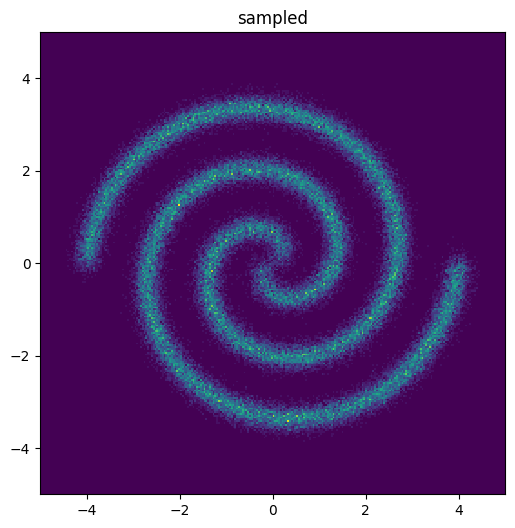

In [5]:

n_bins = 256
hist_range = [[-5, 5], [-5, 5]]

sample1 = rng.random(Float32, 100_000)
sample2 = rng.random(Array2f, (2, 100_000))
x = ref.sample(sample1, sample2)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist2d(x[0], x[1], bins=n_bins, range=hist_range)
ax.set_title("sampled")

Normalizing flows can be used to both sample from a learned distribution, but
also evaluate the probability density function for a given sample. This makes
them very useful in computer graphics, where both properties are often
required.

A normalizing flow is represented by an invertible function $f_\theta$. To
sample random variables $X$ from the learned distribution, we sample latent
variables $Z$ from a normal gaussian distribution $Z \sim p_Z = N(0, 1)$, and
apply the inverse flow $X = f^{-1}_\theta(Z)$.

We parameterize the normalizing flows with coupling and permutation layers
$f_{i;\theta}$, such that $X = f_{0;\theta} \circ f_{1;\theta} \circ \dots
f_{D;\theta} (Z)$. To train the network, we maximize the log sum of the
estimated probability of sampling the sample i.e. $max \sum \text{log}
p_{X;\theta}(X_i)$. To compute this probability, we can sum over the log
determinant of the layers, $p_{X;\theta}(X) = \text{log} \left\vert \text{det} {\partial z
\over \partial x} \right\vert_{\theta} + \text{log} p_{Z}(Z)$.

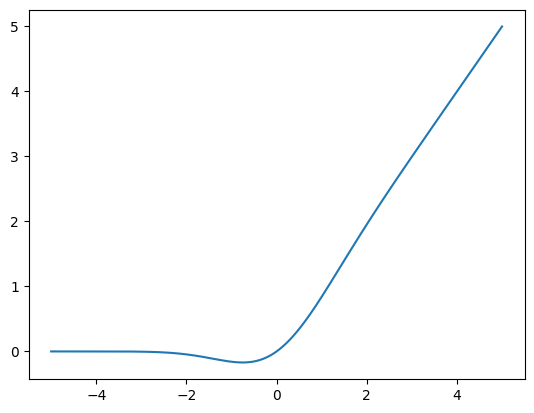

In [6]:


class GELU(nn.Module):
    r""" """

    DRJIT_STRUCT = {}

    def __call__(self, arg: nn.CoopVec, /) -> nn.CoopVec:
        return (
            0.5
            * arg
            * (1 + dr.tanh(dr.sqrt(2 / dr.pi) * (arg + 0.044715 * arg * arg * arg)))
        )


x = dr.linspace(Float32, -5, 5, 1000)
y = GELU()(x)
plt.plot(x, y)

In [7]:


class TwoAlign(nn.Module):
    r""" """

    DRJIT_STRUCT = {}

    def _alloc(
        self, dtype: type[dr.ArrayBase], size: int, rng: dr.random.Generator, /
    ) -> tuple[nn.Module, int]:
        return self, size if size % 2 == 0 else size + 1

    def __call__(self, arg: nn.CoopVec, /) -> nn.CoopVec:
        tp = arg.type
        arg = list(arg)
        if len(arg) % 2 != 0:
            arg.append(tp(0))
        return nn.CoopVec(*arg)

In [8]:


class FlowLayer(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def inverse(self, z: nn.CoopVec) -> nn.CoopVec: ...
    def forward(self, x: nn.CoopVec) -> tuple[nn.CoopVec, Float16]: ...


class PermutationLayer(FlowLayer):
    def __init__(self) -> None:
        super().__init__()

    def inverse(self, z: nn.CoopVec) -> nn.CoopVec:
        z = list(z)
        z.reverse()
        x = nn.CoopVec(z)
        return x

    def forward(self, x: nn.CoopVec) -> tuple[nn.CoopVec, Float16]:
        x = list(x)
        x.reverse()
        z = nn.CoopVec(x)
        ldj = Float16(0)
        return z, ldj


class CouplingLayer(FlowLayer):

    DRJIT_STRUCT = {
        "net": nn.Sequential,
        "config": tuple,
    }

    def __init__(
        self, n_hidden: int = 1, width: int = 2, n_activations: int = 32
    ) -> None:
        super().__init__()

        self.config = (width,)

        sequential = []
        # sequential.append(nn.TriEncode(16, 0))
        sequential.append(TwoAlign())
        sequential.append(nn.Linear(-1, n_activations))
        sequential.append(nn.ReLU())
        for i in range(n_hidden):
            sequential.append(nn.Linear(n_activations, n_activations))
            sequential.append(nn.ReLU())
        sequential.append(nn.Linear(n_activations, width))

        self.net = nn.Sequential(*sequential)

    def inverse(self, z: nn.CoopVec) -> nn.CoopVec:
        r"""
        This function represents the inverse evaluation of the coupling layer,
        i.e. $X = f^{-1}_\theta(Z)$.
        """
        z: list = ArrayXf16(z)
        d = len(z) // 2
        id, z2 = z[:d, :], z[d:, :]
        p = ArrayXf16(self.net(nn.CoopVec(id)))
        log_s, b = p[:d, :], p[d:, :]
        x2 = (z2 - b) * dr.exp(-log_s)
        x = nn.CoopVec(id, x2)
        return x

    def forward(self, x: nn.CoopVec) -> tuple[nn.CoopVec, Float16]:
        r"""
        This function evaluates the foward flow $Z = f_\theta(X)$, as well as
        the log jacobian determinant.
        """
        x = ArrayXf16(x)
        d = len(x) // 2
        id, x2 = x[:d, :], x[d:, :]
        p = ArrayXf16(self.net(nn.CoopVec(id)))
        log_s, b = p[:d, :], p[d:, :]
        z2 = x2 * dr.exp(log_s) + b
        z = nn.CoopVec(id, z2)
        ldj = dr.sum(log_s)
        return z, ldj

    def _alloc(
        self, dtype: type[dr.ArrayBase], size: int, rng: dr.random.Generator, /
    ) -> tuple[nn.Module, int]:

        (width,) = self.config
        if width < 0:
            width = size

        net, _ = self.net._alloc(dtype, width // 2, rng)

        result = CouplingLayer()
        result.net = net

        return result, size


class Flow(nn.Module):

    DRJIT_STRUCT = {
        "layers": list[FlowLayer],
    }

    def __init__(self, *args: FlowLayer) -> None:
        super().__init__()
        self.layers = args

    def sample_base_dist(self, sample: nn.CoopVec) -> nn.CoopVec:
        sample = list(sample)
        z = []
        for i in range(0, len(sample), 2):
            x, y = square_to_std_normal(Array2f(sample[i], sample[i + 1]))
            z.append(Float16(x))
            z.append(Float16(y))

        return nn.CoopVec(*z)

    def eval_log_base_dist(self, z: nn.CoopVec) -> dr.ArrayBase:
        return dr.sum([log_std_normal_pdf(z) for z in z])

    def log_p(self, x: nn.CoopVec) -> Float16:
        """
        This function calculates the log probability of sampling a given value
        `x`.
        """

        log_p = dr.zeros(x.type)

        for layer in self.layers:
            x, ldj = layer.forward(x)
            log_p += Float32(ldj)

        log_p += self.eval_log_base_dist(x)
        return log_p

    def sample(self, sample: nn.CoopVec) -> nn.CoopVec:
        r"""
        Sample a function from the learned target distribution $X \sim
        p_{X;\theta}$, given a sample from the uniform distribution.
        """
        z = self.sample_base_dist(sample)

        for layer in reversed(self.layers):
            z = layer.inverse(z)

        return z

    def _alloc(
        self, dtype: type[dr.ArrayBase], size: int, rng: dr.random.Generator, /
    ) -> tuple[nn.Module, int]:

        layers = []
        for l in self.layers:
            l_new, size = l._alloc(dtype, size, rng)
            layers.append(l_new)

        result = Flow(*layers)
        return result, size

In [9]:

layers = [
    *[CouplingLayer(), PermutationLayer()] * 4,
    # CouplingLayer(),
    # PermutationLayer(),
    # CouplingLayer(),
]
flow: Flow = Flow(*layers)

flow = flow.alloc(TensorXf16, rng=rng)

weights, flow = nn.pack(flow, "training")

Text(0.5, 1.0, 'flow')

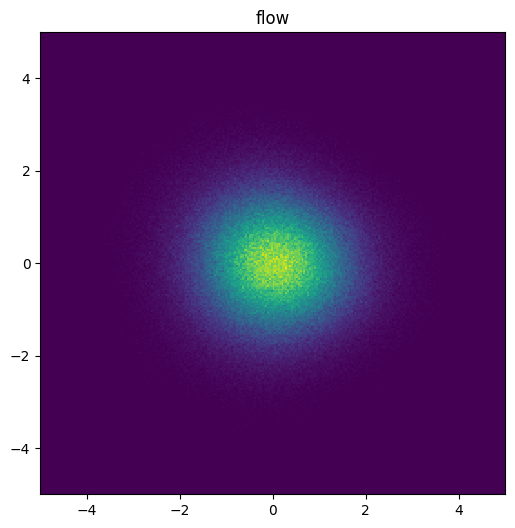

In [10]:
x = ArrayXf16(flow.sample(nn.CoopVec(rng.random(ArrayXf16, (2, 1_000_000)))))
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist2d(x[0], x[1], bins=n_bins, range=hist_range)
ax.set_title("flow")

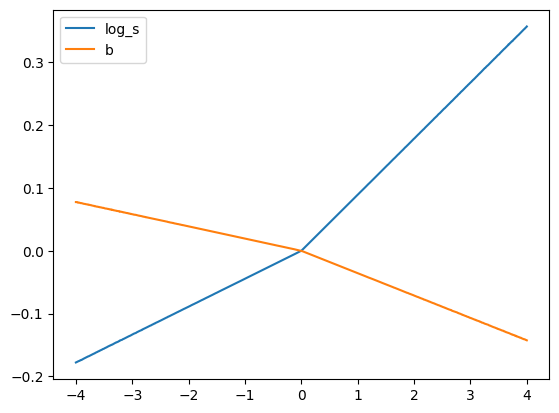

In [11]:
x = dr.linspace(Float16, -4, 4, 1_000)
n = list(flow.layers[0].net(nn.CoopVec(x)))
plt.plot(x, n[0], label="log_s")
plt.plot(x, n[1], label="b")
plt.legend()

In [12]:

opt = Adam(lr=0.001, params={"weights": Float32(weights)})

scaler = GradScaler()

batch_size = 2**14
n = 10_000
its = []
losses = []

iterator = tqdm.tqdm(range(n))
for it in iterator:
    weights[:] = Float16(opt["weights"])

    sample1 = rng.random(Float32, batch_size)
    sample2 = rng.random(Array2f, (2, batch_size))
    x = ref.sample(sample1, sample2)
    x = nn.CoopVec(ArrayXf16(x))

    log_p = flow.log_p(x)
    log_p[dr.isnan(log_p)] = 0
    log_p[dr.isinf(log_p)] = 0
    loss_kl = -dr.mean(log_p)

    dr.backward(scaler.scale(loss_kl))
    scaler.step(opt)

    if (it + 1) % 10 == 0:
        loss = loss_kl.numpy().item()
        losses.append(loss)
        its.append(it)
        iterator.set_postfix({"loss_kl": loss})

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 634.87it/s, loss_kl=5.31]


Text(0.5, 0, 'it')

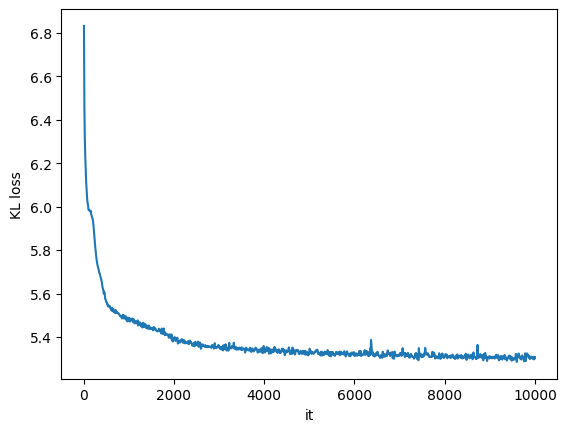

In [13]:
plt.plot(its, losses)
plt.ylabel("KL loss")
plt.xlabel("it")

Text(0.5, 1.0, 'flow')

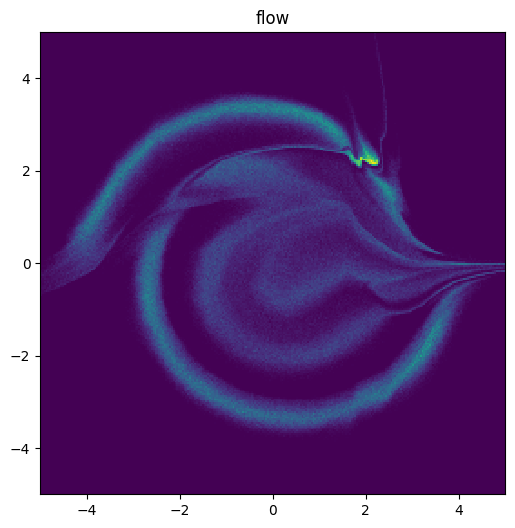

In [14]:
x = ArrayXf16(flow.sample(nn.CoopVec(rng.random(ArrayXf16, (2, 1_000_000)))))
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist2d(x[0], x[1], bins=n_bins, range=hist_range)
ax.set_title("flow")

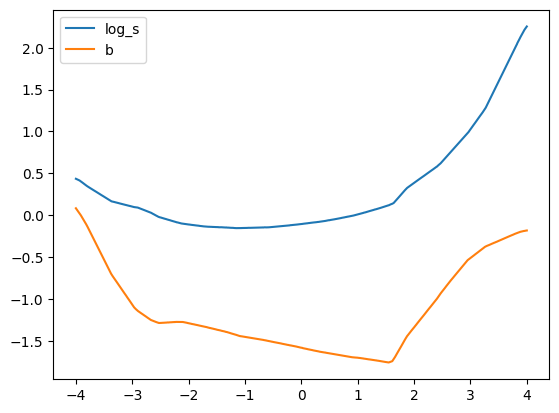

In [15]:
x = dr.linspace(Float16, -4, 4, 1_000)
n = list(flow.layers[0].net(nn.CoopVec(x)))
plt.plot(x, n[0], label="log_s")
plt.plot(x, n[1], label="b")
plt.legend()

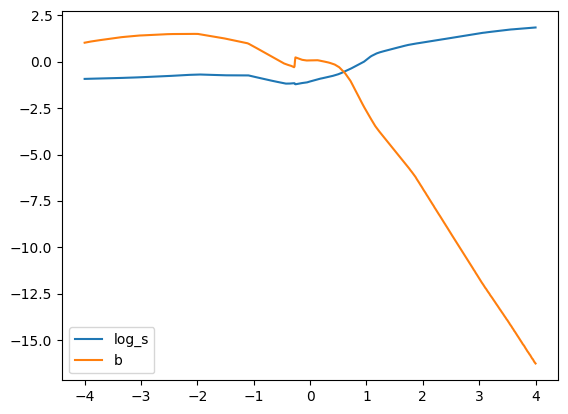

In [16]:
x = dr.linspace(Float16, -4, 4, 1_000)
n = list(flow.layers[2].net(nn.CoopVec(x)))
plt.plot(x, n[0], label="log_s")
plt.plot(x, n[1], label="b")
plt.legend()